In [ ]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from pytensor import gradient

from astropy.io import fits
from astropy.modeling import models

from scipy.signal import find_peaks

# Custom fitter
from astropy.modeling.models import custom_model

import corner
import arviz as az
az.style.use("arviz-darkgrid")

def guess_gen(spec, n):
    guess = []
    peaks, info = find_peaks(spec, height=0., prominence=0.2, width = 0)
    for i in range(len(peaks)):
        center = peaks[i]
        width = info['widths'][i] * 0.6
        for j in np.linspace(center - width, center + width, n):
            guess.append(spec[int(j)])
            guess.append(j)
            guess.append(width / n)

    return guess

# Spectral cube needs to be in the same working directory
name = 'DR21W'
I_hdu = fits.open(name + '_I.FITS')
I_d = np.squeeze(I_hdu[0].data)
I_h = I_hdu[0].header

V_hdu = fits.open(name + '_V.FITS')
V_d = np.squeeze(V_hdu[0].data)
V_h = V_hdu[0].header

# Reading the spectrum of the selected pixel
#Maser B
x = 128
y = 127
start = None
end = None
spec = I_d[start:end, x, y]
V = V_d[start:end, x, y]
d_nu = I_hdu[0].header['CDELT3']
nu_init = I_hdu[0].header['CRVAL3']
x_axis = (np.arange(len(spec)) * d_nu + nu_init) / 1e9

In [ ]:
num = 3
guess = guess_gen(spec, num)
num = len(guess) // 3
plt.plot(spec)
for i in range(num):
    plt.axvline(guess[3 * i + 1], color='r')
    # plt.plot([guess[3 * i + 1], guess[3 * i + 1]], [0, guess[3 * i]], 'r')
guess

In [ ]:
basic_model = pm.Model()

xs = np.arange(len(spec))
with basic_model as model:
    xdata = pm.ConstantData("x", xs)
    # Priors for unknown model parameters
    amp = pm.Uniform("amp", lower=0, upper=np.max(spec)*1.2, shape = num)
    mu = pm.Normal("mu", mu=guess[1::3], sigma=10, shape = num, transform=pm.distributions.transforms.univariate_ordered)
    sigma = pm.HalfNormal("sigma", sigma=10, shape=num)

    gauss_sum = np.sum([amp[i] * pm.math.exp(-0.5 * ((xdata - mu[i]) / sigma[i]) ** 2) for i in range(num)], axis=0)
    # Likelihood (sampling distribution) of observations
    likelihood = pm.Normal("y", mu=gauss_sum, observed=spec, sigma=0.01)

    # inference
    trace = pm.sample(draws=10_000, tune=5_000, cores = 24, chains = 24, discard_tuned_samples=False, step = pm.NUTS(),
                      initvals={'amp': guess[0::3], 'mu': guess[1::3], 'sigma': guess[2::3]})

In [ ]:
# from astropy.modeling.fitting import LevMarLSQFitter
# guess = guess_gen(spec, 3)
# g = models.Gaussian1D(amplitude=guess[0], mean=guess[1], stddev=guess[2],
#                     bounds={'amplitude': (0, np.max(spec)), 
#                             'mean': (guess[1] - 3*guess[2], guess[-2] + 3*guess[-1]), 
#                             'stddev': (0, len(spec))})

# for i in range(3, len(guess), 3):
#     g += models.Gaussian1D(amplitude=guess[i], mean=guess[i+1], stddev=guess[i+2],
#                     bounds={'amplitude': (0, np.max(spec)), 
#                             'mean': (guess[1] - 3*guess[2], guess[-2] + 3*guess[-1]), 
#                             'stddev': (0, len(spec))})
# fitter = LevMarLSQFitter()
# g_fit = fitter(g, xs, spec, maxiter=10000)

fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey='row')
axs[0][0].set(title=name + " Least Squared Stokes I Fit", ylabel = "Flux Density (Jy)")
axs[0][0].plot(x_axis, spec, 'o', color = 'green', label = 'Data', markersize = 4)
axs[0][0].plot(x_axis, g_fit(xs), label = 'Fit', color = 'c')
axs[0][0].plot(x_axis, spec - g_fit(xs), 'x', markersize = 3, color = 'red', label = 'Residuals')
axs[0][0].errorbar(x_axis, spec, yerr = 0.01, fmt = 'none', ecolor = 'k', elinewidth = 1, capsize = 2, alpha = 0.2)

for i in range(3):
    axs[0][0].plot(x_axis, g_fit[i](xs), label = f'Gauss{i}', alpha = 0.5)
#     print('Amp:' , f"{amp[i]:.2f}", 'Center:', f"{mu[i]:.2f}", 'Width:', f"{sig[i]:.2f}", sep='\t') # Print to file

axs[0][0].legend()
axs[1][0].plot(x_axis, (spec - g_fit(xs)), label = 'Residuals')
axs[1][0].set(xlabel = "Frequency (GHz)")
axs[1][0].legend()
print('Chi2:', np.sum((spec - g_fit(xs))**2))


post = trace.posterior
mean = post.mean(dim=["chain", "draw"])
amp = mean.amp.values
mu = mean.mu.values
sig = mean.sigma.values
model = np.zeros(len(spec))
x = np.arange(len(spec))
for i in range(num):
    model += amp[i] * np.exp(-((x - mu[i]) ** 2) / (2 * sig[i] ** 2))
axs[0][1].set(title=name + " MCMC Stokes I Fit")
axs[0][1].plot(x_axis, spec, 'o', color = 'green', label = 'Data', markersize = 4)
axs[0][1].plot(x_axis, model, label = 'Fit', color = 'c')
axs[0][1].plot(x_axis, spec - model, 'x', markersize = 3, color = 'red', label = 'Residuals')
axs[0][1].errorbar(x_axis, spec, yerr = 0.01, fmt = 'none', ecolor = 'k', elinewidth = 1, capsize = 2, alpha = 0.2)

for i in range(3):
    axs[0][1].plot(x_axis, amp[i] * np.exp(-((x - mu[i]) ** 2) / (2 * sig[i] ** 2)), label = f'Gauss{i}', alpha = 0.5)
#     print('Amp:' , f"{amp[i]:.2f}", 'Center:', f"{mu[i]:.2f}", 'Width:', f"{sig[i]:.2f}", sep='\t') # Print to file

axs[0][1].legend()
axs[1][1].plot(x_axis, (spec - model), label = 'Residuals')
axs[1][1].set(xlabel = "Frequency (GHz)")
axs[1][1].legend()
print('Chi2:', np.sum((spec - model)**2))

plt.show()
I_fit = model

In [ ]:
axes = az.plot_trace(trace, compact=False);

corner.corner(trace, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt = '.4e');

post = trace.posterior
mean = post.mean(dim=["chain", "draw"])
amp = mean.amp.values
mu = mean.mu.values
sig = mean.sigma.values
model = np.zeros(len(spec))
x = np.arange(len(spec))
for i in range(num):
    model += amp[i] * np.exp(-((x - mu[i]) ** 2) / (2 * sig[i] ** 2))

fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
axs[0].set(title=name + " Stokes I Fit", ylabel = "Flux Density (Jy)")
axs[0].plot(x_axis, spec, 'o', color = 'green', label = 'Data', markersize = 4)
axs[0].plot(x_axis, model, label = 'Fit', color = 'c')
axs[0].plot(x_axis, spec - model, 'x', markersize = 3, color = 'red', label = 'Residuals')
axs[0].errorbar(x_axis, spec - model, yerr = 0.01, fmt = 'none', ecolor = 'k', elinewidth = 1, capsize = 2, alpha = 0.2)

for i in range(num):
    axs[0].plot(x_axis, amp[i] * np.exp(-((x - mu[i]) ** 2) / (2 * sig[i] ** 2)), label = f'Gauss{i}', alpha = 0.5)
    print('Amp:' , f"{amp[i]:.2f}", 'Center:', f"{mu[i]:.2f}", 'Width:', f"{sig[i]:.2f}", sep='\t') # Print to file

axs[0].legend()
axs[1].plot(x_axis, (spec - model), label = 'Residuals')
axs[1].set(xlabel = "Frequency (GHz)")
axs[1].legend()
print('Chi2:', np.sum((spec - model)**2))
plt.show()
I_fit = model

In [ ]:
stokesVmodel = pm.Model()
compoments = np.array([amp[i] * np.exp(-0.5 * ((xs - mu[i]) / sig[i]) ** 2) for i in range(num)])

with stokesVmodel as model:
    I = pm.Data("I", I_fit)
    d_I = pm.Data("d_I", np.gradient(compoments, d_nu, axis = 1))
    alpha = pm.Flat("alpha", shape = 1)
    beta = pm.Flat("beta", shape = num)
    V_fit = alpha * I + pm.math.sum([beta[i] * d_I[i] for i in range(num)], axis=0)
    V_likelihood = pm.Normal("V", mu=V_fit, observed=V, sigma=0.01)
    
    V_trace = pm.sample(draws=10_000, tune=5_000, cores = 24, chains = 24, discard_tuned_samples=False, step = pm.NUTS())

In [ ]:
axes = az.plot_trace(V_trace, compact=False);

corner.corner(V_trace, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt = '.3e');

post = V_trace.posterior
mean = post.mean(dim=["chain", "draw"])
alpha = mean.alpha.values
beta = mean.beta.values
V_model = alpha * I_fit + np.sum([beta[i] * np.gradient(compoments, d_nu, axis = 1)[i] for i in range(num)], axis=0)

fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
axs[0].set(title=name + " Stokes V Fit", ylabel = "Flux Density (Jy)")
axs[0].plot(x_axis, V - alpha * I_fit, 'o', color = 'green', label = 'Data', markersize = 4)
axs[0].plot(x_axis, V_model - alpha * I_fit, label = 'Fit', color = 'c')
axs[0].plot(x_axis, V - V_model, 'x', markersize = 3, color = 'red', label = 'Residuals')
axs[0].errorbar(x_axis, V - alpha * I_fit, yerr = 0.01, fmt = 'none', ecolor = 'k', elinewidth = 1, capsize = 2, alpha = 0.2)

for i in range(num):
    axs[0].plot(x_axis, beta[i] * np.gradient(compoments[i], d_nu), label = f'Beta{i}', alpha = 0.5)
    # print('Amp:' , f"{amp[i]:.2f}", 'Center:', f"{mu[i]:.2f}", 'Width:', f"{sig[i]:.2f}", sep='\t') # Print to file

axs[0].legend()
axs[1].plot(x_axis, (V - V_model), label='Residuals')
axs[1].set(xlabel = "Frequency (GHz)")
axs[1].legend()
print('Chi2:', np.sum((V - V_model)**2))
plt.show()

Chi2: 4.500610595154113
Chi2: 0.03976023322835269


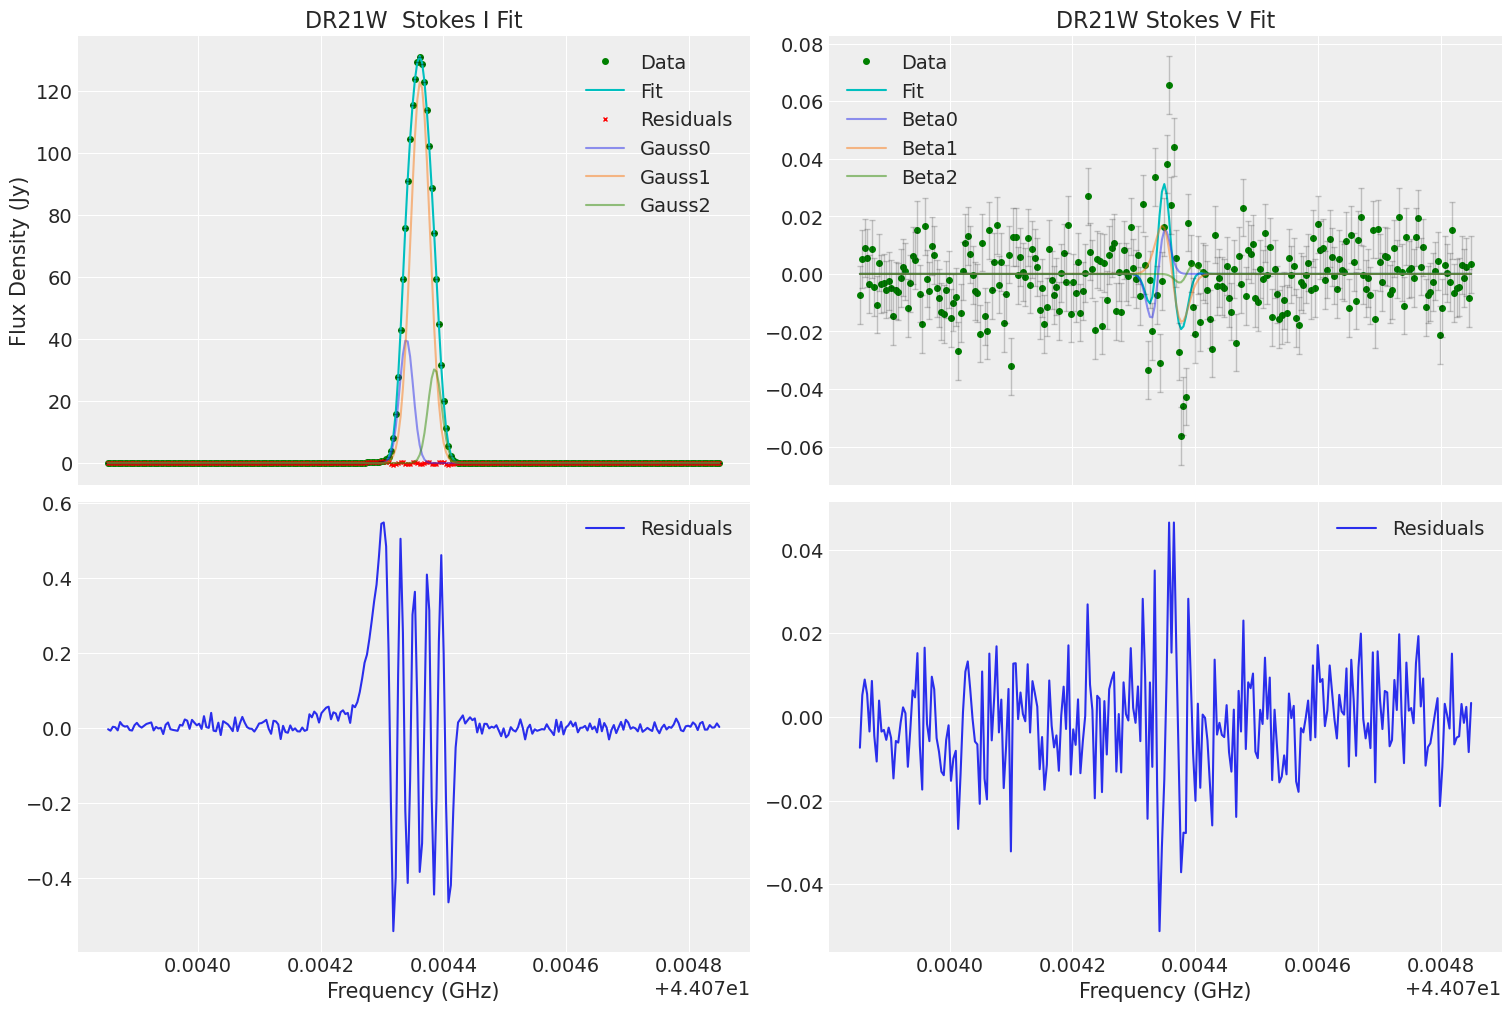

In [21]:
x = np.arange(len(spec))
model = np.zeros(len(spec))
for i in range(num):
    model += amp[i] * np.exp(-((x - mu[i]) ** 2) / (2 * sig[i] ** 2))

fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=False)
axs[0][0].set(title=name + "  Stokes I Fit", ylabel = "Flux Density (Jy)")
axs[0][0].plot(x_axis, spec, 'o', color = 'green', label = 'Data', markersize = 4)
axs[0][0].plot(x_axis, model, label = 'Fit', color = 'c')
axs[0][0].plot(x_axis, spec - model, 'x', markersize = 3, color = 'red', label = 'Residuals')
axs[0][0].errorbar(x_axis, spec, yerr = 0.01, fmt = 'none', ecolor = 'k', elinewidth = 1, capsize = 2, alpha = 0.2)

for i in range(3):
    axs[0][0].plot(x_axis, amp[i] * np.exp(-((x - mu[i]) ** 2) / (2 * sig[i] ** 2)), label = f'Gauss{i}', alpha = 0.5)
#     print('Amp:' , f"{amp[i]:.2f}", 'Center:', f"{mu[i]:.2f}", 'Width:', f"{sig[i]:.2f}", sep='\t') # Print to file

axs[0][0].legend()
axs[1][0].plot(x_axis, (spec - model), label = 'Residuals')
axs[1][0].set(xlabel = "Frequency (GHz)")
axs[1][0].legend()
print('Chi2:', np.sum((spec - model)**2))

I_fit = model

axs[0][1].set(title=name + " Stokes V Fit")
axs[0][1].plot(x_axis, V - alpha * I_fit, 'o', color = 'green', label = 'Data', markersize = 4)
axs[0][1].plot(x_axis, V_model - alpha * I_fit, label = 'Fit', color = 'c')
# axs[0][1].plot(x_axis, V - V_model, 'x', markersize = 3, color = 'red', label = 'Residuals')
axs[0][1].errorbar(x_axis, V - alpha * I_fit, yerr = 0.01, fmt = 'none', ecolor = 'k', elinewidth = 1, capsize = 2, alpha = 0.2)

for i in range(num):
    axs[0][1].plot(x_axis, beta[i] * np.gradient(compoments[i], d_nu), label = f'Beta{i}', alpha = 0.5)

axs[0][1].legend()
axs[1][1].plot(x_axis, (V - V_model), label = 'Residuals')
axs[1][1].set(xlabel = "Frequency (GHz)")
axs[1][1].legend()
print('Chi2:', np.sum((V - V_model)**2))

plt.show()